In [1]:
# Data Processing
import pandas as pd
from PIL import Image
from examples.generator import generate_dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Torch 
import torch
import torch.nn as nn
import torch.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset

# LTN
from ltn_imp.automation.knowledge_base import KnowledgeBase
from ltn_imp.automation.data_loaders import LoaderWrapper

## Data Processing

In [2]:
data = pd.DataFrame(generate_dataset(100))

In [3]:
image_paths = [item for item in data[0]]
images = []
for path in image_paths:
    try:
        img = Image.open(path).convert('RGB')  # Convert to RGB to ensure consistency
        img = np.array(img)
        img_tensor = torch.tensor(img, dtype=torch.float32)  # Convert to PyTorch tensor
        images.append(img_tensor)
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        
labels = torch.tensor(data[1])

In [4]:
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label
    
batch_size = 25

# Split the data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(images,labels, test_size=0.2, random_state=42)

# Create the training dataset
train_dataset = ImageDataset(train_data, train_labels)

# Create the test dataset
test_dataset = ImageDataset(test_data, test_labels)

# Create the training dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        

In [5]:
train_dataloader = LoaderWrapper(variables=["i"],num_classes=3, target="y", loader=train_dataloader)

In [6]:
print(f"Number of training images: {len(train_data)}")
print(f"Number of training labels: {len(train_labels)}")
print(f"Number of test images: {len(test_data)}")
print(f"Number of test labels: {len(test_labels)}")

Number of training images: 80
Number of training labels: 80
Number of test images: 20
Number of test labels: 20


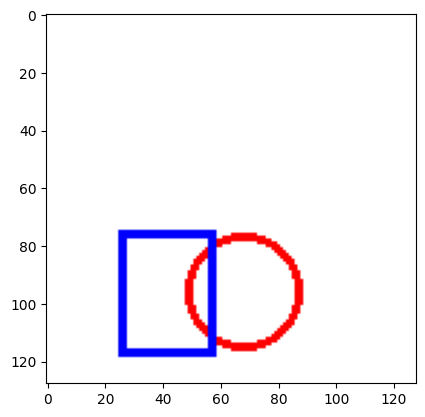

In [7]:
plt.imshow(train_data[0].numpy().astype(np.uint8))

## Models

In [8]:
class CircleDetector(pl.LightningModule):
    def __init__(self):
        super(CircleDetector, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 3)  # Output: (x_center, y_center, radius)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.mse_loss(outputs, labels)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [9]:
class RectangleDetector(pl.LightningModule):
    def __init__(self):
        super(RectangleDetector, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 4)  # Output: (x_top_left, y_top_left, x_br, y_br)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.mse_loss(outputs, labels)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

## Rules and Functions

In [10]:
class BoundingBox(torch.nn.Module):
    def forward(self, C, R, TL, BR):
        pass

    def __call__(self, *args):
        return self.forward(args)
    
class Inside(torch.nn.Module):
    def forward(self, TL1, BR1, TL2, BR2):
        return (TL1 < TL2).all() and (BR1 < BR2).all()

    def __call__(self, *args):
        return self.forward(args)
    
class Outside(torch.nn.Module):
    def forward(self, TL1, BR1, TL2, BR2):
        return (TL1 > BR2).any() or (BR1 > TL2).any()

    def __call__(self, *args):
        return self.forward(args)
    
class Intersect(torch.nn.Module):
    def __init__(self):
        super(Intersect, self).__init__()
        self.outside = Outside()
        self.inside = Inside()

    def forward(self, TL1, BR1, TL2, BR2):
        return not self.outside(TL1, BR1, TL2, BR2) and not self.inside(TL1, BR1, TL2, BR2)

    def __call__(self, *args):
        return self.forward(args)

In [11]:
from ltn_imp.parsing.expression_transformations import transform
from ltn_imp.parsing.parser import LTNConverter

converter = LTNConverter(predicates={"Circle" : ..., "Rect" : ... , "bounding_box": ..., "inside" : ..., "outside": ..., "intersect": ...})

# TODO: NLTK doesnt allow 2 letter variables. so x1 -> means X left, x2 -> means X right 

ancillary_rules = [
    "forall c r. exists t1 b1. bounding_box(c, r, t1, b1) <-> (t1 = c - r / 2 and b1 = c + r / 2)",
    "forall t1 b1 t2 b2. inside(t1, b1, t2, b2) <-> (t1 < t2 and b1 < b2)",
    "forall t1 b1 t2 b2. outside(t1, b1, t2, b2) <-> (t1 > b2 or b1 > b2)",
    "forall t1 b1 t2 b2. intersect(t1, b1, t2, b2) <-> (not outside(t1, b1, t2, b2) and not inside(t1, b1, t2, b2))"
]

learning_rules = [
    "forall i. Circle(i, c, r) and Rect(i, t1, b2) and bounding_box(c, r, t1, b2) and inside(t1, b2, t1, b2) -> y = in",
    "forall i. Circle(i, c, r) and Rect(i, t1, b2) and bounding_box(c, r, t1, b2) and outside(t1, b2, t1, b2) -> y = out",
    "forall i. Circle(i, c, r) and Rect(i, t1, b2) and bounding_box(c, r, t1, b2) and intersect(t1, b2, t1, b2) -> y = int"
]

In [15]:
for rule in ancillary_rules:
    converter(rule)
    print(str(converter))

(all c r.exists t1 b1.bounding_box(c,r,t1,b1) <-> ((t1 = sub(c,div(r,2))) & (b1 = add(c,div(r,2)))))
(all t1 b1 t2 b2.inside(t1,b1,t2,b2) <-> (lt(t1,t2) & lt(b1,b2)))
(all t1 b1 t2 b2.outside(t1,b1,t2,b2) <-> (mt(t1,b2) | mt(b1,b2)))
(all t1 b1 t2 b2.intersect(t1,b1,t2,b2) <-> (-outside(t1,b1,t2,b2) & -inside(t1,b1,t2,b2)))


In [16]:
for rule in learning_rules:
    converter(rule)
    print(str(converter))

((all i.Circle(i,c,r) & Rect(i,t1,b2) & bounding_box(c,r,t1,b2) & inside(t1,b2,t1,b2)) -> (y = in))
((all i.Circle(i,c,r) & Rect(i,t1,b2) & bounding_box(c,r,t1,b2) & outside(t1,b2,t1,b2)) -> (y = out))
((all i.Circle(i,c,r) & Rect(i,t1,b2) & bounding_box(c,r,t1,b2) & intersect(t1,b2,t1,b2)) -> (y = int))


## Training

In [14]:
expresssions = [*ancillary_rules, ]
rule_to_data_loader_mapping = {}

for rule in ancillary_rules:
    rule_to_data_loader_mapping[rule] = None

predicates={"Circle" : CircleDetector(),
            "Rect" : RectangleDetector(),    
            "bounding_box": BoundingBox(),   # type: ignore
            "inside" : Inside(),             # type: ignore
            "outside": Outside(),            # type: ignore
            "intersect": Intersect() }      # type: ignore

functions = {}
connective_impls={}
quantifier_impls={}
constant_mapping = {"in" : torch.tensor([1,0,0]), "out" : torch.tensor([0,1,0]), "int" : torch.tensor([0,0,1])}

kb = KnowledgeBase(
    expressions = expresssions,
    rule_to_data_loader_mapping = rule_to_data_loader_mapping,
    predicates = predicates,
    functions = functions,
    connective_impls = connective_impls,
    quantifier_impls = quantifier_impls,
    constant_mapping=constant_mapping
)

AttributeError: 'KnowledgeBase' object has no attribute 'converter'

In [ ]:
kb.optimize(num_epochs=100, log_steps=11)

ValueError: Model expects 2 arguments, but got 0.